In [89]:
import pandas as pd
import pedpy
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from scipy.stats import gaussian_kde

In [90]:
def extract_category_from_filename(filename: str) -> str:
    """
    Extracts the category part from a given filename, taking into account
    special cases like 'mix_sorted' and 'mix_random'.

    The category is extracted based on its position in the filename, which is
    assumed to follow the pattern: '../data/country/category_restOfTheFilename.csv'.

    Parameters:
    - filename (str): The full path of the file.

    Returns:
    - str: The extracted category.
    """
    # Extract the basename of the file (e.g., 'female_41_21.csv')
    basename = os.path.basename(filename)

    # Split by underscores and reconstruct the category part
    parts = basename.split('_')
    if parts[0].startswith("mix"):
        # Handles 'mix_sorted' and 'mix_random'
        category = "_".join(parts[:2])
    else:
        # Handles 'female', 'male', etc.
        category = parts[0]

    return category

In [91]:
# load_file and constants
categories = ["female", "male", "mix_sorted", "mix_random"]
colors = {
    "aus": "blue",
    "ger": "black",
    "jap": "orange",
    "chn": "red",
    "pal": "green",
}
max_radius = 4
max_g = 4

x_from = -1.4
x_to = 1.4
y_from = -2
y_to = -1
rename_mapping = {
    "ID": "id",
    "t(s)": "time",
    "x(m)": "x",
    "y(m)": "y",
}
column_types = {
    "id": int,
    "gender": int,
    "time": float,
    "x": float,
    "y": float,
}
countries = [
    "aus",
    "ger",
    "jap",
    "chn",
    "pal",
]
files = {}
for country in countries:
    files[country] = glob.glob(f"../data/{country}/*.csv")


def load_file(filename: str, filter: bool = False) -> pedpy.TrajectoryData:
    def calculate_fps(data: pd.DataFrame) -> int:
        """Calculate fps based on the mean difference of the 'time' column."""
        mean_diff = data.groupby("id")["time"].diff().dropna().mean()
        return int(round(1 / mean_diff))

    def set_column_types(data: pd.DataFrame, col_types) -> pd.DataFrame:
        """Set the types of the dataframe columns based on the given column types."""
        # Ensure columns are in data before type casting
        valid_types = {
            col: dtype for col, dtype in col_types.items() if col in data.columns
        }
        return data.astype(valid_types)

    data = pd.read_csv(filename)
    data.rename(columns=rename_mapping, inplace=True)
    data = set_column_types(data, column_types)
    fps = calculate_fps(data)
    if filter:
        data = data[
            (data["x"] > x_from)
            & (data["x"] < x_to)
            & (data["y"] > y_from)
            & (data["y"] < y_to)
        ].dropna()
    return pedpy.TrajectoryData(data=data, frame_rate=fps)

In [92]:
csv_file = "../app_data/proximity_analysis_results_euc.csv"
df = pd.read_csv(csv_file)
df

,country,file,type,id,frame,same_gender_proximity_next,diff_gender_proximity_next,same_gender_proximity_prev,diff_gender_proximity_prev
0,aus,aus/male_21_01.csv,male,1,0,1.117678,NaN,0.583283,NaN
1,aus,aus/male_21_01.csv,male,1,25,1.170431,NaN,0.660884,NaN
2,aus,aus/male_21_01.csv,male,1,50,1.085280,NaN,0.617669,NaN
3,aus,aus/male_21_01.csv,male,1,75,1.065505,NaN,0.576679,NaN
4,aus,aus/male_21_01.csv,male,1,100,1.076599,NaN,0.639603,NaN
...,...,...,...,...,...,...,...,...,...
1207129,pal,pal/mix_sorted_30_01.csv,mix_sorted,87,5760,NaN,NaN,NaN,NaN
1207130,pal,pal/mix_sorted_30_01.csv,mix_sorted,87,5761,NaN,NaN,NaN,NaN
1207131,pal,pal/mix_sorted_30_01.csv,mix_sorted,87,5762,NaN,NaN,NaN,NaN
1207132,pal,pal/mix_sorted_30_01.csv,mix_sorted,87,5763,NaN,NaN,NaN,NaN


In [93]:
def pdf_all_distances(df):
    """
    Calculates the PDF of all distance columns combined into one series in the dataframe.

    Parameters:
    - df (pd.DataFrame): The dataframe containing the distance columns.

    Returns:
    - KDE object for the combined distances.
    """
    distance_columns = ['same_gender_proximity_next', 'diff_gender_proximity_next',
                        'same_gender_proximity_prev', 'diff_gender_proximity_prev']

    combined_distances = pd.concat([df[col].dropna() for col in distance_columns])

    return gaussian_kde(combined_distances)

In [94]:
def pdf_all_categories(df):
    """
    Calculates and plots the PDF of all distance columns, grouped by categories extracted from the filenames.

    Parameters:
    - df (pd.DataFrame): The dataframe with the file column and distance columns.

    Returns:
    - dict of dict: Outer dict keys are categories, inner dict keys are distance columns with their KDE objects.
    """
    # Adding a category column to the dataframe using the provided function
    df['category'] = df['file'].apply(extract_category_from_filename)

    categories = df['category'].unique()
    result = {}

    for category in categories:
        df_cat = df[df['category'] == category]
        result[category] = pdf_all_distances(df_cat)

    return result

In [95]:
def plot_pdf_all_distances(ax, kde, color="gray", title='PDF of All Distances Combined'):
    x_grid = np.linspace(np.min(kde.dataset), np.max(kde.dataset), 1000)
    pdf_values = kde.evaluate(x_grid)
    plt.plot(x_grid, pdf_values, label=title, color=color)
    if color == 'gray':
        plt.fill_between(x_grid, pdf_values, color=color, alpha=0.1)
    #ax.set_title(title)
    ax.set_xlabel('Distance / m', fontsize=14)
    ax.set_ylabel('Density', fontsize=14)
    ax.set_xlim([0, 4])

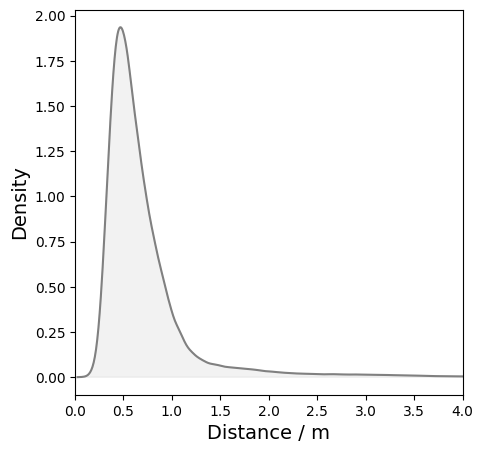

In [96]:
kde = pdf_all_distances(df)
fig, ax = plt.subplots(figsize=(5, 5))
plot_pdf_all_distances(ax=ax,kde=kde)

Integral of the PDF: 0.9999999050416278, with error estimate: 6.943221186651548e-05


/var/folders/xp/t78pqmf50rb4s9vh6gdz0ykr0000gq/T/ipykernel_30007/992928749.py:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, error = quad(kde, -np.inf, np.inf)


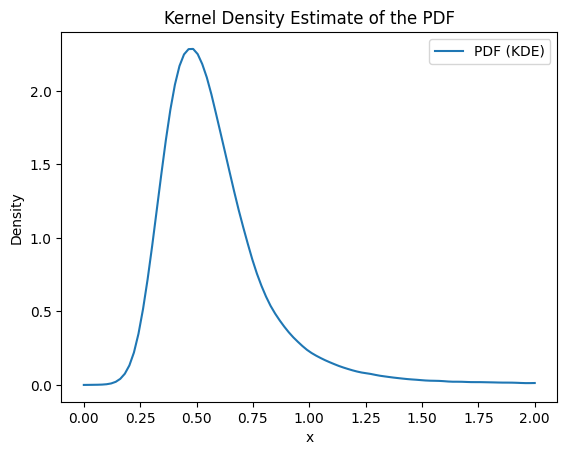

In [97]:
from scipy.integrate import quad

df_aus = df[df['country'] == 'chn']
distance_columns = ['same_gender_proximity_next', 'diff_gender_proximity_next',
                    'same_gender_proximity_prev', 'diff_gender_proximity_prev']

combined_distances = pd.concat([df_aus[col].dropna() for col in distance_columns])

kde = gaussian_kde(combined_distances)

x_values = np.linspace(0, 2, 100)

pdf_values = kde(x_values)

integral, error = quad(kde, -np.inf, np.inf)

print(f"Integral of the PDF: {integral}, with error estimate: {error}")

plt.plot(x_values, pdf_values, label='PDF (KDE)')
plt.title('Kernel Density Estimate of the PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()


In [98]:
kde_categories = pdf_all_categories(df)
# kde = pdf_all_distances(df)
# colors = colors = ["blue","orange","red","green"]

# fig, ax = plt.subplots(figsize=(5, 5))
# plot_pdf_all_distances(ax,kde, title="all")

# # Assuming kde_categories is a dictionary where keys are category names and values are KDE objects
# for i, (category, kde) in enumerate(kde_categories.items()):
#     plot_pdf_all_distances(ax, kde, title=category, color=colors[i % len(colors)])

# plt.legend()
# plt.savefig("pdfs/pdf_all.pdf")

In [99]:
import matplotlib.pyplot as plt

def calculate_kde_difference(kde1, kde2, grid_points=1000):
    """
    Calculates the difference between two KDE estimates over a common evaluation grid.

    Parameters:
    - kde1, kde2: KDE objects from scipy.stats.gaussian_kde or similar.
    - grid_points (int): Number of points in the common evaluation grid.

    Returns:
    - x_grid (np.ndarray): Common evaluation grid.
    - diff (np.ndarray): Difference between the KDE estimates on the grid.
    """
    # Determine the range for the common evaluation grid
    min_bound = min(np.min(kde1.dataset), np.min(kde2.dataset))
    max_bound = max(np.max(kde1.dataset), np.max(kde2.dataset))

    x_grid = np.linspace(min_bound, max_bound, grid_points)

    # Evaluate both KDEs on this grid
    kde1_values = kde1.evaluate(x_grid)
    kde2_values = kde2.evaluate(x_grid)

    # Calculate the difference
    diff = kde1_values - kde2_values

    return x_grid, diff

def plot_kde_difference(x_grid, diff, title='Difference between', category1="", category2="", xmax=4, ymin=-0.5, ymax=0.45):
    """
    Plots the difference between two KDE estimates.

    Parameters:
    - x_grid (np.ndarray): Common evaluation grid.
    - diff (np.ndarray): Difference between the KDE estimates on the grid.
    - title (str): Title for the plot.
    """
    plt.figure(figsize=(5, 5))
    plt.plot(x_grid, diff, label='KDE Difference', color='blue')
    plt.fill_between(x_grid, 0, diff, color='blue', alpha=0.1)
    #plt.title(f"{title} {category1} and {category2}")
    plt.xlabel('Distance / m', fontsize=14)
    plt.xlim([0, xmax])
    plt.ylim([ymin, ymax])
    plt.ylabel('Density Difference', fontsize=14)
    plt.axhline(0, color='black', lw=0.5)  # Zero difference line for reference
    plt.grid(True, which='both', linestyle='--', alpha=0.3)

    plt.savefig(f"pdfs/pdf_diff_{category1}_{category2}.pdf")
    plt.show()

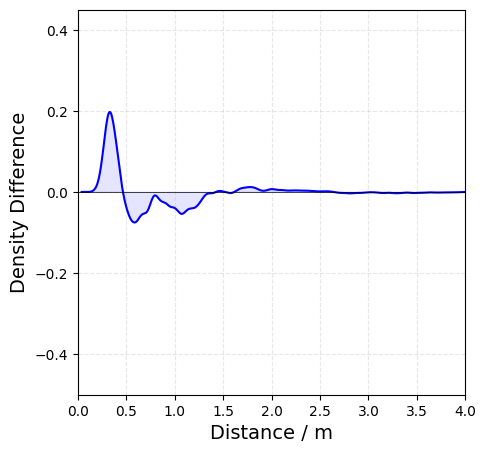

In [100]:
x_grid, diff = calculate_kde_difference(kde_categories['female'], kde_categories['male'])
plot_kde_difference(x_grid, diff, category1="female", category2="male")

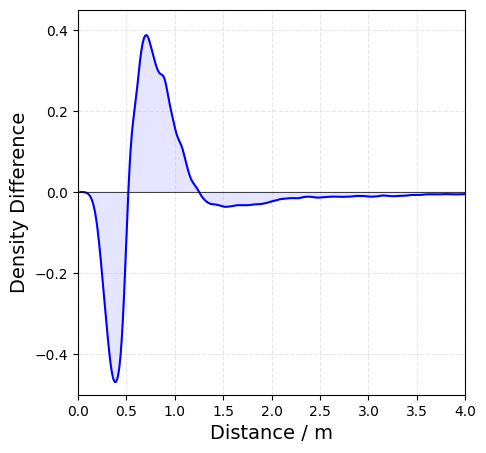

In [101]:
x_grid, diff = calculate_kde_difference(kde_categories['mix_sorted'], kde_categories['mix_random'])
plot_kde_difference(x_grid, diff, category1="mix sorted", category2="mix random")

In [102]:
def pdf_next_prev(df, category):
    next_columns = [
        "same_gender_proximity_next",
        "diff_gender_proximity_next",
    ]
    if category != "all":
        category_df = df[df["category"] == category]
    else:
        category_df = df

    prev_columns = [
        "same_gender_proximity_prev",
        "diff_gender_proximity_prev",
    ]
    next_distances = pd.concat([category_df[col].dropna() for col in next_columns])
    prev_distances = pd.concat([category_df[col].dropna() for col in prev_columns])

    next_kde = gaussian_kde(next_distances)
    prev_kde = gaussian_kde(prev_distances)

    min_bound = min(np.min(next_kde.dataset), np.min(prev_kde.dataset))
    max_bound = max(np.max(next_kde.dataset), np.max(prev_kde.dataset))

    x_grid = np.linspace(min_bound, max_bound, 1000)

    # Evaluate both KDEs on this grid
    next_kde_values = next_kde.evaluate(x_grid)
    prev_kde_values = prev_kde.evaluate(x_grid)

    # Calculate the difference
    diff = next_kde_values - prev_kde_values
    plot_kde_difference(x_grid, diff, category1="next", category2=f"prev: {category}", ymin=-0.1, ymax=0.1, xmax=2)

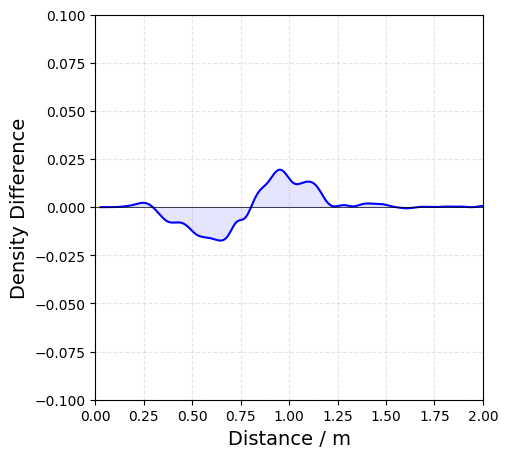

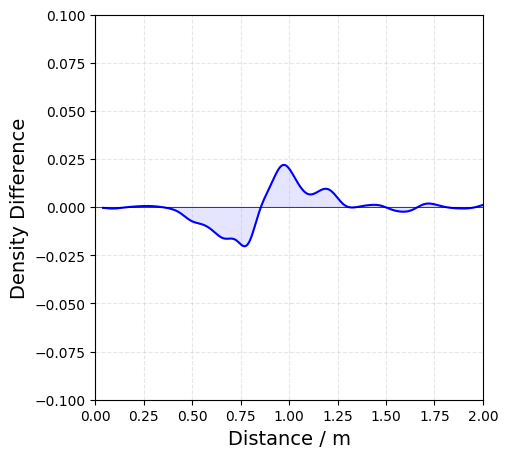

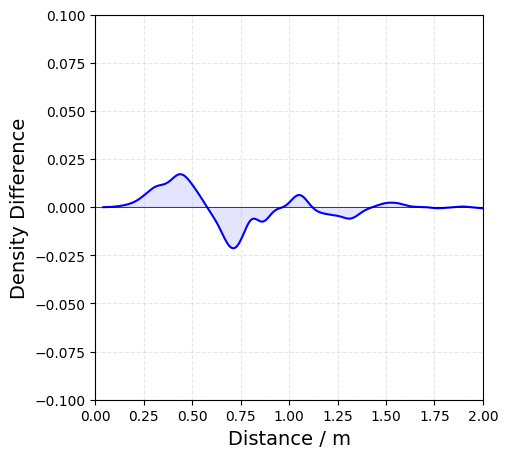

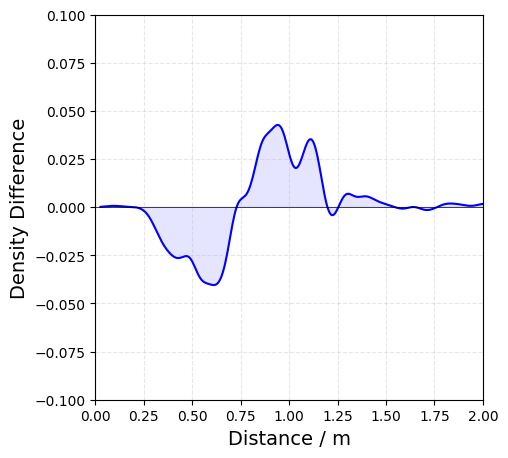

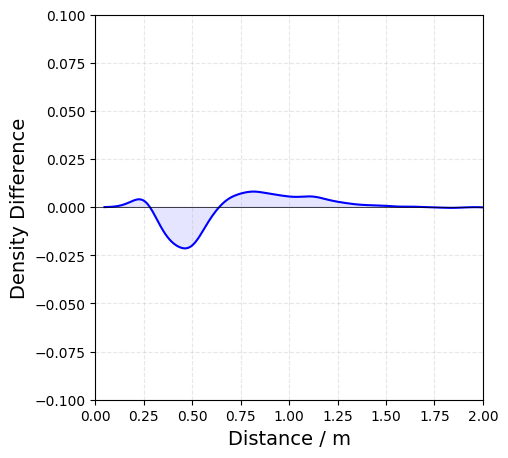

In [103]:
pdf_next_prev(df, "all")

for category in categories:
    pdf_next_prev(df, category)

<Axes: xlabel='same_gender_proximity_prev', ylabel='Density'>

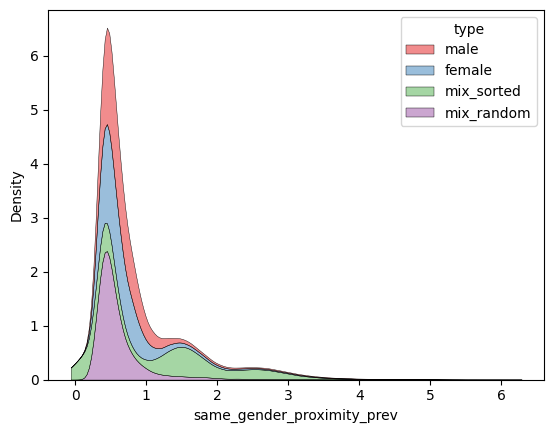

In [104]:
import seaborn as sns

sns.kdeplot(
    data=df,
    x="same_gender_proximity_prev",
    hue="type",
    multiple="stack",
    fill=True,
    common_norm=False,
    palette="Set1",
    alpha=0.5,
    linewidth=0.3,
)

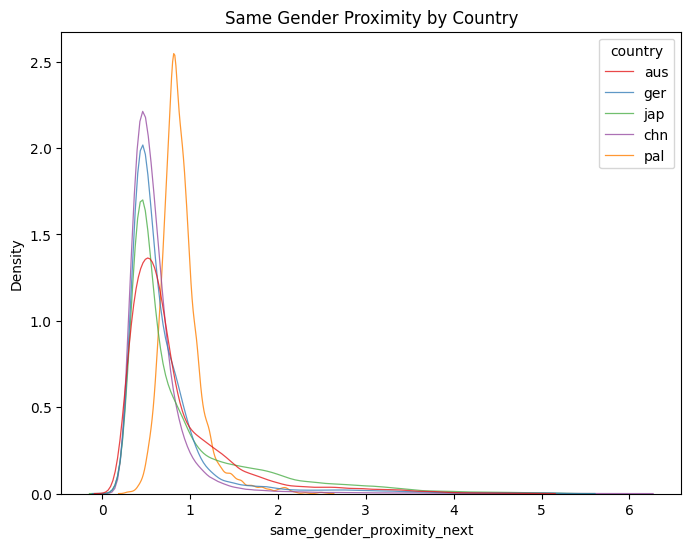

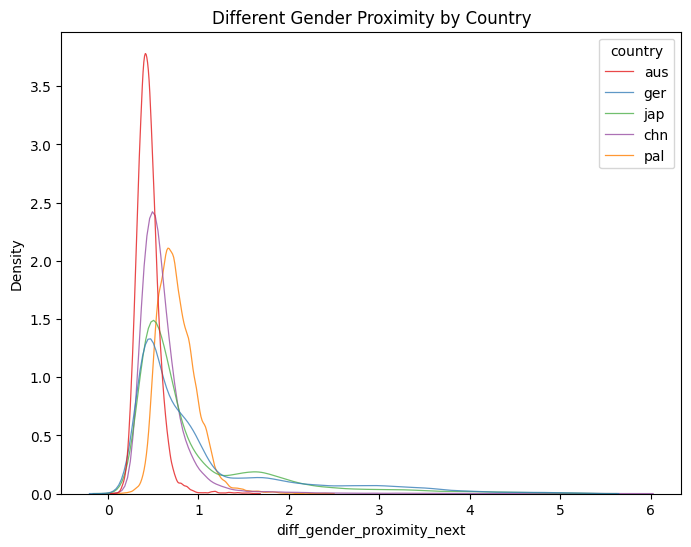

In [105]:
df_sorted = df.sort_values(by='country', ascending=False)
plt.figure(figsize=(8, 6)) 
sns.kdeplot(
    data=df,
    x="same_gender_proximity_next",
    hue="country",
    multiple="layer",
    fill=False,
    common_norm=False,
    palette="Set1",
    alpha=0.8,
    linewidth=0.9,
)
plt.title('Same Gender Proximity by Country')
plt.show()

plt.figure(figsize=(8, 6)) 
sns.kdeplot(
    data=df,
    x="diff_gender_proximity_next",
    hue="country",
    multiple="layer",
    fill=False,
    common_norm=False,
    palette="Set1",
    alpha=0.8,
    linewidth=0.9,
)
plt.title('Different Gender Proximity by Country')
plt.show()

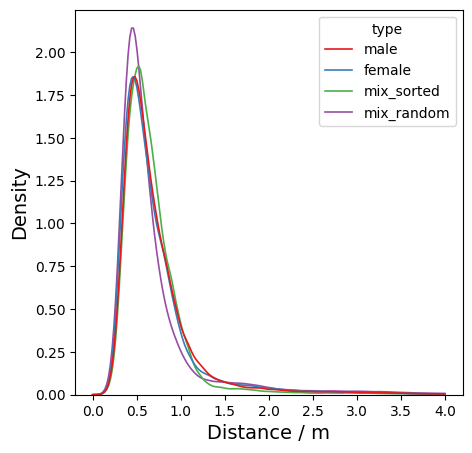

In [142]:
melted_df = df.melt(id_vars=['country', 'file', 'type', 'id', 'frame'],
                    value_vars=['same_gender_proximity_next', 'diff_gender_proximity_next',
                                'same_gender_proximity_prev', 'diff_gender_proximity_prev'],
                    var_name='distance_type', value_name='distance')

# Now use seaborn to plot
fig, ax = plt.subplots(figsize=(5, 5))
sns.kdeplot(
    data=melted_df,
    x="distance",
    hue="type",  # Differentiates the lines by 'type' column
    #col="distance_type",  # Creates a separate plot for each distance type
    multiple="layer",
    fill=False,
    common_norm=False,  # Treats each subgroup as a separate distribution for normalization
    palette="Set1",
    alpha=1,
    linewidth=1.2,
    clip=(0, 4),
    ax=ax
)
ax.set_xlabel('Distance / m', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
fig.savefig("pdfs/pdf_all_seaborn_type_layer.pdf")

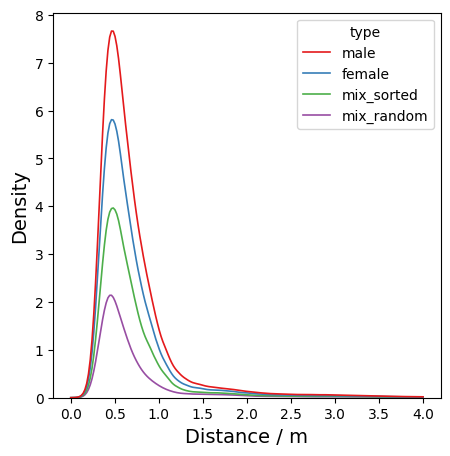

In [107]:
melted_df = df.melt(id_vars=['country', 'file', 'type', 'id', 'frame'],
                    value_vars=['same_gender_proximity_next', 'diff_gender_proximity_next',
                                'same_gender_proximity_prev', 'diff_gender_proximity_prev'],
                    var_name='distance_type', value_name='distance')

# Now use seaborn to plot
fig, ax = plt.subplots(figsize=(5, 5))
sns.kdeplot(
    data=melted_df,
    x="distance",
    hue="type",  # Differentiates the lines by 'type' column
    #col="distance_type",  # Creates a separate plot for each distance type
    multiple="stack",
    fill=False,
    common_norm=False,  # Treats each subgroup as a separate distribution for normalization
    palette="Set1",
    alpha=1.,
    linewidth=1.2,
    clip=(0, 4),
    ax=ax
)
ax.set_xlabel('Distance / m', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
fig.savefig("pdfs/pdf_all_seaborn_type_stack.pdf")

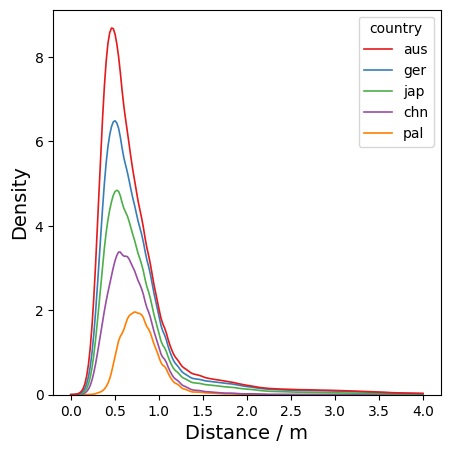

In [108]:
melted_df = df.melt(id_vars=['country', 'file', 'type', 'id', 'frame'],
                    value_vars=['same_gender_proximity_next', 'diff_gender_proximity_next',
                                'same_gender_proximity_prev', 'diff_gender_proximity_prev'],
                    var_name='distance_type', value_name='distance')

# Now use seaborn to plot
fig, ax = plt.subplots(figsize=(5, 5))
sns.kdeplot(
    data=melted_df,
    x="distance",
    hue="country",  # Differentiates the lines by 'type' column
    multiple="stack",
    fill=False,
    common_norm=False,  # Treats each subgroup as a separate distribution for normalization
    palette="Set1",
    alpha=1,
    linewidth=1.2,
    clip=(0, 4),
    ax=ax
)
ax.set_xlabel('Distance / m', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
fig.savefig("pdfs/pdf_all_seaborn_country_stack.pdf")

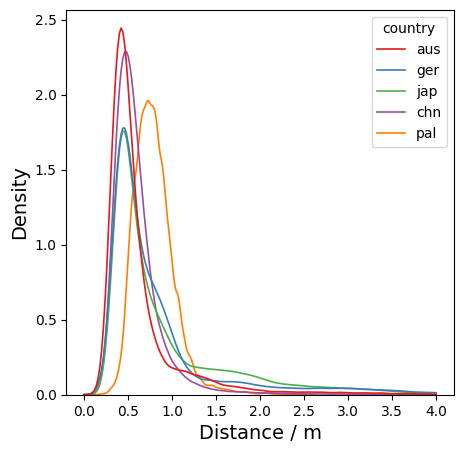

In [109]:
melted_df = df.melt(id_vars=['country', 'file', 'type', 'id', 'frame'],
                    value_vars=['same_gender_proximity_next', 'diff_gender_proximity_next',
                                'same_gender_proximity_prev', 'diff_gender_proximity_prev'],
                    var_name='distance_type', value_name='distance')

# Now use seaborn to plot
fig, ax = plt.subplots(figsize=(5, 5))
sns.kdeplot(
    data=melted_df,
    x="distance",
    hue="country",  # Differentiates the lines by 'type' column
    multiple="layer",
    fill=False,
    common_norm=False,  # Treats each subgroup as a separate distribution for normalization
    palette="Set1",
    alpha=1,
    linewidth=1.2,
    clip=(0, 4),
    ax=ax
)
ax.set_xlabel('Distance / m', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
fig.savefig("pdfs/pdf_all_seaborn_country_layer.pdf")

In [151]:
for country in countries:
    country_df = df[(df["country"] == country)]
    cleaned_df = country_df[["same_gender_proximity_next", "same_gender_proximity_prev"]].replace([np.inf, -np.inf], np.nan).dropna()
    kde = gaussian_kde(cleaned_df[["same_gender_proximity_next", "same_gender_proximity_prev"]].T)
    print(f"{country=}: Bandwidth:", kde.factor)  # This shows the default bandwidth factor

country='aus': Bandwidth: 0.18951986537287896
country='ger': Bandwidth: 0.1556663376288566
country='jap': Bandwidth: 0.1480712993233442
country='chn': Bandwidth: 0.11943700679294406
country='pal': Bandwidth: 0.16680339910769126


aus
ger
jap
chn
pal


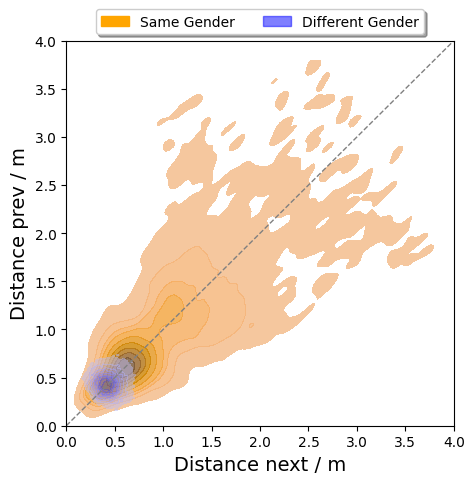

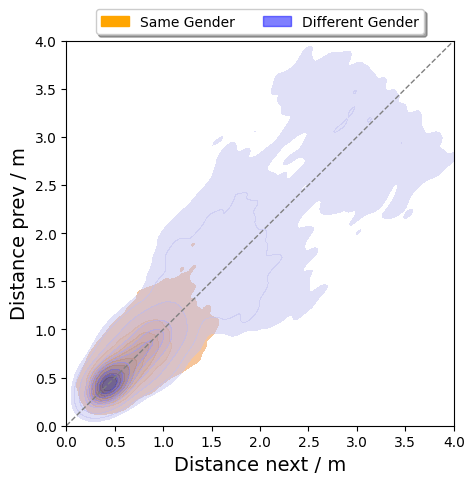

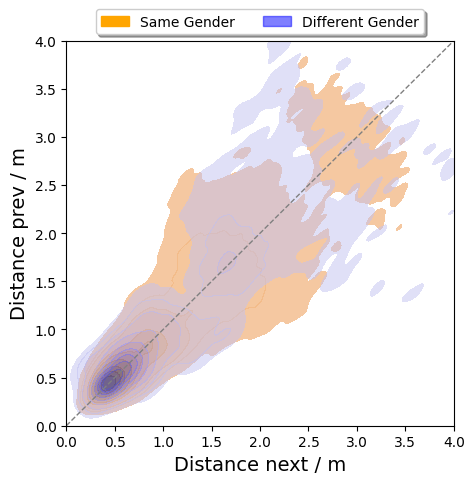

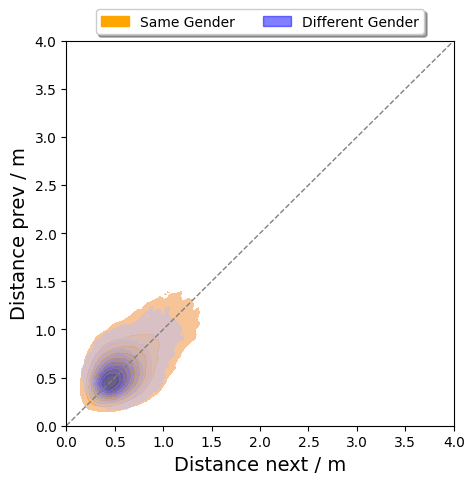

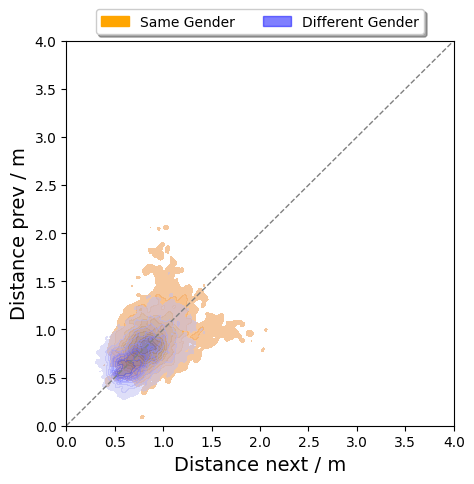

In [154]:
import matplotlib.patches as mpatches
# these bandwidths are copy/pasted from the cell above
bandwidths = {
    'aus': 0.5,#0.1895,
    'ger': 0.5,#0.1557,
    'jap': 0.5,#0.1481,
    'chn': 0.5,#0.1194,
    'pal': 0.5,#0.1668
}
colors = [
    "blue",
    "orange",
    "red",
    "green",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]
palette = dict(zip(countries, colors))
for country in countries[:]:
    print(country)
    country_df = df[(df["country"] == country)]
    fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(5, 5))

    sns.kdeplot(
        data=country_df,
        x="same_gender_proximity_next",
        y="same_gender_proximity_prev",
        fill=True,
        alpha=0.8,
        clip=(0, 4),
        cbar=False,
        ax=ax1,
        color='orange',
        bw_adjust=bandwidths[country],
        legend=False,
    )
    sns.kdeplot(
        data=country_df,
        x="diff_gender_proximity_next",
        y="diff_gender_proximity_prev",
        fill=True,
        alpha=0.5,
        # linewidth=0.3,
        clip=(0, 4),
        ax=ax1,
        cbar=False,
        legend=False,
        bw_adjust=bandwidths[country],
        color='blue',
    )
    # add diagonal line
    ax1.plot([0, 4], [0, 4], linestyle="--", color="gray", linewidth=1, label="y = x")

    ax1.set_xlabel("Distance next / m", fontsize=14)
    ax1.set_ylabel("Distance prev / m", fontsize=14)
    country_patch = mpatches.Patch(color='white', label=f'{country}')
    same_patch = mpatches.Patch(color='orange', label='Same Gender')
    different_patch = mpatches.Patch(color='blue', label='Different Gender', alpha=0.5)
    diag_line_patch = mpatches.Patch(color='black', label='y = x', linestyle='--')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2, fancybox=True, shadow=True,handles=[same_patch, different_patch])
    ax1.set_xlim(0, 4)
    ax1.set_ylim(0, 4)
    fig.savefig(f"pdfs/distance_prev_next_{country}.pdf")

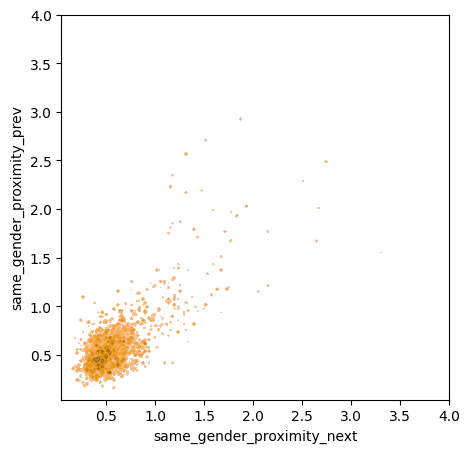

In [146]:
country_df = df[(df["country"] == 'chn')]
fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(5, 5))
sns.kdeplot(
        data=country_df,
        x="same_gender_proximity_next",
        y="same_gender_proximity_prev",
        fill=True,
        alpha=0.8,
        clip=(0, 4),
        cbar=False,
        ax=ax1,
        color='orange',
        legend=False,
        bw_adjust=0.1,
        cut=0
     )
# sns.kdeplot(
#     data=country_df,
#     x="diff_gender_proximity_next",
#     y="diff_gender_proximity_prev",
#     fill=True,
#     alpha=0.5,
#     # linewidth=0.3,
#     clip=(0, 4),
#     ax=ax1,
#     cbar=False,
#     legend=False,
#     color='blue',
# )
fig.savefig("delme.png")

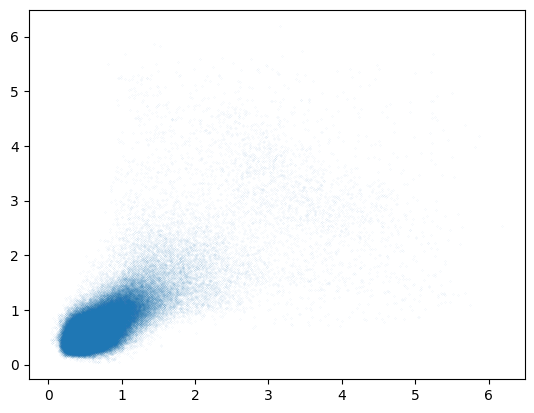

In [153]:
country_df = df[(df["country"] == 'chn')]

plt.plot(country_df['same_gender_proximity_next'], country_df['same_gender_proximity_prev'], ".", ms=0.05)